In [37]:
import os, time
import pickle, re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pprint import pprint
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

In [29]:
import warnings
warnings.simplefilter("ignore")

In [39]:
pickles_dir = '/content/drive/MyDrive/news_analysis/data_pickles'
###########################################################
# features_train
features_train_p = os.path.join(pickles_dir, 'features_train.pickle')
with open(features_train_p, 'rb') as data:
  features_train = pickle.load(data)

# labels_train
ytrain_p = os.path.join(pickles_dir, 'y_train.pickle')
with open(ytrain_p, 'rb') as data:
  labels_train = pickle.load(data)

# features_test
features_test_p = os.path.join(pickles_dir, 'features_test.pickle')
with open(features_test_p, 'rb') as data:
  features_test = pickle.load(data)
  
# labels_test
ytest_p = os.path.join(pickles_dir, 'y_test.pickle')
with open(ytest_p, 'rb') as data:
  labels_test = pickle.load(data)

# Dataframe
df_cleaned_p = os.path.join(pickles_dir, 'df_cleaned.pickle')
with open(df_cleaned_p, 'rb') as data:
  df = pickle.load(data)

# TF-IDF object
tfidf_p = os.path.join(pickles_dir, 'tfidf.pickle')
with open(tfidf_p, 'rb') as data:
  tfidf = pickle.load(data)

print(features_train.shape)
print(features_test.shape)
print(df.shape)

(6947, 300)
(869, 300)
(8684, 5)


In [3]:
df.head()

,headline,links,cleaned_article,labels,numeric_labels
0,Sindhu targets Olympics gold,https://www.thehindu.com/sport/other-sports/si...,world champion p v sindhu said it is time to l...,sports,6
1,Shotgun selection trials from January 20,https://www.thehindu.com/sport/other-sports/sh...,the second and third shotgun selection trials ...,sports,6
2,Supreme Fragrance wins SI Oaks in style,https://www.thehindu.com/sport/races/star-frag...,robert foley trained supreme fragrance nakhat ...,sports,6
3,"Prevalent Force, Stormy Knight, Indian Democra...",https://www.thehindu.com/sport/races/prevalent...,prevalent force stormy knight indian democrat ...,sports,6
4,Awesome One excels,https://www.thehindu.com/sport/races/awesome-o...,awesome one excelled when the horses were exer...,sports,6


In [4]:
svc_0 =svm.SVC(random_state=8)
svc_0.fit(features_train, labels_train)
svc_pred = svc_0.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, svc_0.predict(features_train)))
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The training accuracy is: 
0.9663163955664316
The test accuracy is: 
0.8481012658227848


In [6]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=20,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=10, 
                                   random_state=8,
                                   return_train_score=True
                                   )

# Fit the random search model
random_search.fit(features_train, labels_train)
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START C=0.01, degree=4, gamma=0.001, kernel=poly, probability=True
[CV 1/3; 1/20] END C=0.01, degree=4, gamma=0.001, kernel=poly, probability=True;, score=(train=0.239, test=0.239) total time=  23.5s
[CV 2/3; 1/20] START C=0.01, degree=4, gamma=0.001, kernel=poly, probability=True
[CV 2/3; 1/20] END C=0.01, degree=4, gamma=0.001, kernel=poly, probability=True;, score=(train=0.239, test=0.239) total time=  23.4s
[CV 3/3; 1/20] START C=0.01, degree=4, gamma=0.001, kernel=poly, probability=True
[CV 3/3; 1/20] END C=0.01, degree=4, gamma=0.001, kernel=poly, probability=True;, score=(train=0.239, test=0.239) total time=  22.8s
[CV 1/3; 2/20] START C=0.01, degree=3, gamma=0.0001, kernel=linear, probability=True
[CV 1/3; 2/20] END C=0.01, degree=3, gam

In [10]:
#The best hyperparameters from Random Search are:
# {'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}
# The test accuracy is: 
# 0.8665132336018412
best_svc = random_search.best_estimator_
best_svc.fit(features_train, labels_train)
svc_pred = best_svc.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, best_svc.predict(features_test)))
# Classification report
print("Classification report")
print(classification_report(labels_test,best_svc.predict(features_test)))

The training accuracy is: 
1.0
The test accuracy is: 
0.8665132336018412
Classification report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       129
           1       0.88      0.86      0.87       101
           2       0.85      0.85      0.85       136
           3       0.83      0.92      0.87       208
           4       0.88      0.79      0.83       117
           5       0.86      0.86      0.86        63
           6       0.96      0.89      0.92       115

    accuracy                           0.87       869
   macro avg       0.87      0.86      0.87       869
weighted avg       0.87      0.87      0.87       869



In [ ]:
model_dir = '/content/drive/MyDrive/news_analysis/src/models'
svc_path = os.path.join(model_dir,'best_svc.pickle')
with open(svc_path, 'wb') as output:
    pickle.dump(best_svc, output)
    
with open(svc_path, 'rb') as model:
  model = pickle.load(model)

In [ ]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}
df_svm_res = pd.DataFrame(d, index=[1])
res_path = os.path.join(model_dir, 'df_result.pickle')    
with open(res_path, 'rb') as output:
  df_res = pickle.load(output)

df_res = pd.concat([df_res, df_svm_res])

res_path = os.path.join(model_dir, 'df_result.pickle')    
with open(res_path, 'wb') as output:
  pickle.dump(df_res, output)

In [22]:
df_res 

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,1.0,0.818182
1,SVM,1.0,0.866513


In [8]:
# Create the parameter grid based on the results of random search 
C = [.01, .1, .2]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=10,
                           return_train_score=True
                           )

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)
best_svc1 = grid_search.best_estimator_
best_svc1.fit(features_train, labels_train)
svc_pred = best_svc1.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc1.predict(features_train)))
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 1/3; 1/21] START C=0.01, kernel=linear, probability=True....................
[CV 1/3; 1/21] END C=0.01, kernel=linear, probability=True;, score=(train=0.251, test=0.230) total time=  22.0s
[CV 2/3; 1/21] START C=0.01, kernel=linear, probability=True....................
[CV 2/3; 1/21] END C=0.01, kernel=linear, probability=True;, score=(train=0.250, test=0.250) total time=  22.0s
[CV 3/3; 1/21] START C=0.01, kernel=linear, probability=True....................
[CV 3/3; 1/21] END C=0.01, kernel=linear, probability=True;, score=(train=0.246, test=0.245) total time=  22.1s
[CV 1/3; 2/21] START C=0.1, kernel=linear, probability=True.....................
[CV 1/3; 2/21] END C=0.1, kernel=linear, probability=True;, score=(train=0.827, test=0.814) total time=  15.0s
[CV 2/3; 2/21] START C=0.1, kernel=linear, probability=True.....................
[CV 2/3; 2/21] END C=0.1, kernel=linear, probability=True;, score=(train=0.823, test=0.

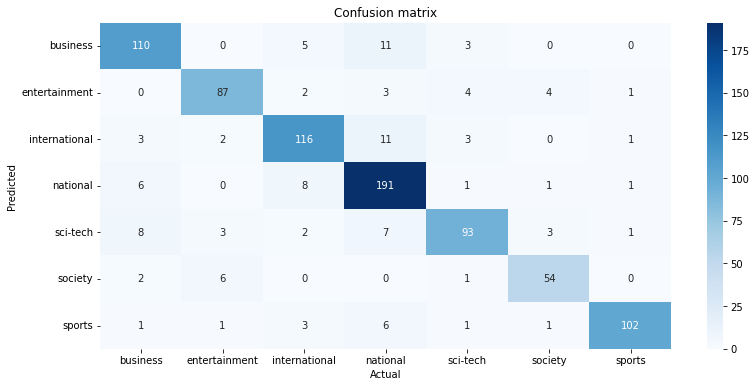

In [36]:
aux_df = df[['labels', 'numeric_labels']].drop_duplicates().sort_values('numeric_labels')
conf_matrix = confusion_matrix(labels_test, best_svc.predict(features_test))
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues",
            fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

## Naive Bays

In [24]:
mnbc = MultinomialNB()
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, mnbc.predict(features_train)))
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, mnbc_pred))
# Classification report
print("Classification report")
print(classification_report(labels_test,mnbc_pred))

The training accuracy is: 
0.777601842521952
The test accuracy is: 
0.7733026467203682
Classification report
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       129
           1       0.71      0.83      0.76       101
           2       0.81      0.63      0.71       136
           3       0.68      0.93      0.79       208
           4       0.84      0.76      0.80       117
           5       0.84      0.57      0.68        63
           6       0.90      0.74      0.81       115

    accuracy                           0.77       869
   macro avg       0.80      0.75      0.76       869
weighted avg       0.79      0.77      0.77       869



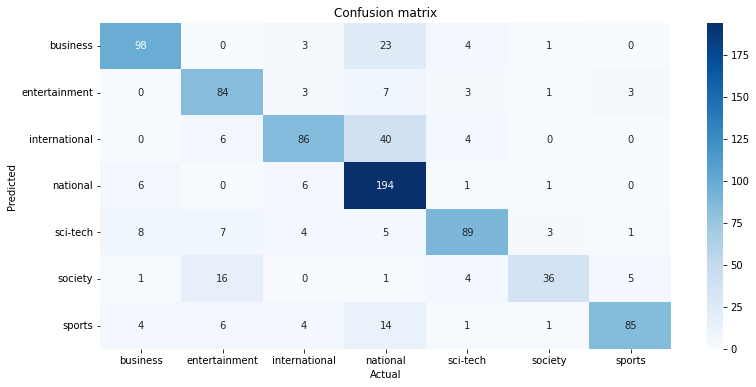

In [34]:
aux_df = df[['labels', 'numeric_labels']].drop_duplicates().sort_values('numeric_labels')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['labels'].values, 
            yticklabels=aux_df['labels'].values,
            cmap="Blues",
            fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

## Features Plot

In [25]:
features = np.concatenate((features_train,features_test), axis=0)
labels = np.concatenate((labels_train,labels_test), axis=0)
print(features.shape)
print(labels.shape)

(7816, 300)
(7816,)


         PC1        PC2  label     label_name
0  46.766380  20.181530      0       business
1 -54.351597  10.868467      6         sports
2  35.585629 -49.797157      4       sci-tech
3  12.404442  -4.038505      2  international
4 -52.015381   5.126844      6         sports


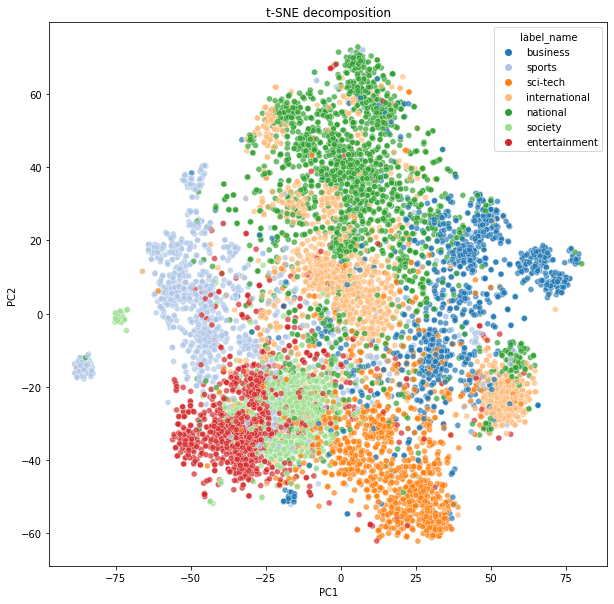

In [33]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "PCA decomposition"  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label']

    # Get labels name
    category_names = {0:'business', 
                      1:'entertainment',
                      2:'international',
                      3:'national',
                      4:'sci-tech',
                      5:'society',
                      6:'sports'
                     }
     # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})
    print(df_full.head())
    # Plot
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    palette='tab20',
                    alpha=.7).set_title(title);
plot_dim_red("TSNE", 
             features=features, 
             labels=labels,
             n_components=2)

In [48]:
def remove_stop_words(data):
  word_list = word_tokenize(data)
  stops = set(stopwords.words("english"))
  filtered_words = [word for word in word_list if word not in stops]
  return " ".join(filtered_words)

def lemmatize_doc(doc):
  """
  Lemmatize a doc
  """
  lemma_sentence=[]
  wnl = WordNetLemmatizer()
  for word, tag in pos_tag(word_tokenize(doc)):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lemma = word
    else:
      lemma = wnl.lemmatize(word, wntag)
    lemma_sentence.append(lemma)
    lemma_sentence.append(" ")
  return "".join(lemma_sentence)

def clean(data):
  """
  Args:
  data: single sentence
  """
  # remove functions body
  data = re.sub(r'(?<={)[^}]*', '', data)
  #remove function name
  data = re.sub('([\w]+ getPlayerID)', '', data)
  data = re.sub('loadAsyncURL.*', '', data)
  #remove unicodes
  data = re.sub(r'[^\x00-\x7f]',r'', data)
  data = data.replace('\x0c', '')
  data = data.replace('\x0d', '')
  data = data.replace('\f', '')
  data = data.replace('\n', ' ')

  # removing mentions 
  data = re.sub("@\S+", "", data)
  # remove market tickers
  data = re.sub("\$", "", data)
  # remove urls
  data = re.sub("https?:\/\/.*[\r\n]*", "", data)

  # removing hashtags 
  data = re.sub("#", "", data)

  # Remove ticks and the next character
  #Notley's tactful -> Notley tactful
  data = re.sub("\'\w+", '', data)

  #Remove Numbers
  data = re.sub(r'\w*\d+\w*', '', data)

  # remove all other symbols numbers and white spaces
  char_safe = ['.', '?', '!',]
  data = "".join([character if (character.isalnum() or character in char_safe) else " " for character in data])
  #remove ., ?, !
  data = data.replace('.', ' ')
  data = data.replace('?', ' ')
  data = data.replace('!', ' ')
  # remove extra white spce in the middle
  data = re.sub(" +", " ", data)
  #remove extra spaces in the beginning
  data = data.strip()

  #lowercase the text
  data = data.lower()
  return data
### Check the result on random text
labels_decode = {
                0:'business', 
                1:'entertainment',
                2:'international',
                3:'national',
                4:'sci-tech',
                5:'society',
                6:'sports'
              }
model_dir = '/content/drive/MyDrive/news_analysis/src/models'
pickles_dir = '/content/drive/MyDrive/news_analysis/data_pickles'
rfc_path = os.path.join(model_dir,'best_svc.pickle')
# tfidf_p = os.path.join(pickles_dir, 'tfidf.pickle')

with open(rfc_path, 'rb') as model:
  model = pickle.load(model)

# with open(tfidf_p, 'rb') as tfidf:
#   tfidf = pickle.load(tfidf)

text = r'''Twitter Inc said on Friday its engineering head Michael Montano and design chief Dantley Davis would step down from their roles by the end of this month, as part of a broader management restructuring at the social networking site.

(Sign up to our Technology newsletter, Today's Cache, for insights on emerging themes at the intersection of technology, business and policy. Click here to subscribe for free.)

The moves come just days after co-founder Jack Dorsey stepped down as chief executive officer and handed over the reins to Chief Technology Officer Parag Agrawal.

Twitter said Agrawal, in his newly assumed role, has decided to reorganise the leadership structure at the company and shift to a general manager model for consumer, revenue and core tech that would oversee all core teams across engineering, product management, design and research.'''
text = clean(text)
feat = tfidf.transform([text])
labels_decode[model.predict(feat.toarray())[0]]

'business'

In [45]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, model.predict(features_test)))

The test accuracy is: 
The test accuracy is: 
0.8665132336018412
